Objective: Demonstrate my knowledge of SQL below using a popular toy SQLite database, called Chinook, which represents a digital music collection. See the documentation at:

https://github.com/lerocha/chinook-database/blob/master/ChinookDatabase/DataSources/Chinook_Sqlite.sqlite

## Load database

In [2]:
import sqlite3
import matplotlib.pyplot as plt

# downloaded from https://github.com/lerocha/chinook-database/blob/master/ChinookDatabase/DataSources/Chinook_Sqlite.sqlite
db = 'Chinook_Sqlite.sqlite' 

#Establish connection and cursor objects to facilitate interaction with database
conn = sqlite3.connect(db)
db = conn.cursor()


List the names of the tables in the dataset

In [42]:
res = db.execute("SELECT name FROM sqlite_master WHERE type='table';")
for name in res:
    print(name[0])

Album
Artist
Customer
Employee
Genre
Invoice
InvoiceLine
MediaType
Playlist
PlaylistTrack
Track


## Example 1 - Album lengths

**Objective:** Determine how many songs are on each album and which album has the most songs on it.

**SQL skills demonstrated:** basic joins, group by, common table expressions, sum, max

In [27]:
query = """with album_length as (
                select a.title 
                    , count(distinct t.name) album_length
                from album a
                left join track t on t.albumid = a.albumid
                group by 1
                )
            
            select album_length
                , count(*)
            from album_length
            group by 1
            """
alb_lengths = []
counts = []

for row in db.execute(query):
    alb_lengths.append(row[0])
    counts.append(row[1])

Graph the number of albums of different lengths

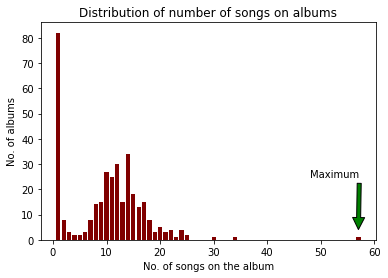

In [34]:
plt.bar(alb_lengths, counts, color ='maroon')
plt.xlabel("No. of songs on the album") 
plt.ylabel("No. of albums") 
plt.title("Distribution of number of songs on albums") 
plt.annotate('Maximum', xy=(57, 3), xytext=(48, 25),
            arrowprops=dict(facecolor='green', shrink=.05))
plt.show() 

Find the name of the album that has 57 songs on it. Also presumably the albums with 1 song on them are singles.

In [39]:
query = """with album_length as (
                select a.title 
                    , count(distinct t.name) album_length
                from album a
                left join track t on t.albumid = a.albumid
                group by 1
                )
            
            select title
                , max(album_length)
            from album_length
            """

for row in db.execute(query):
    print('The album with the most songs on it is called '+ row[0] + '!')

The album with the most songs on it is called Greatest Hits!


## Example 2 - Sales

**Objective:** Using invoicing data, figure out which artists have over $50 in sales in this database and rank 'The' artists in terms of sales.

**SQL skills demonstrated:** common table expressions, subqueries, group by, joins, window functions

In [50]:
query = """ with sales as (
                    select trackid
                        , sum(unitprice * quantity) as sale_amount
                    from invoiceline
                    group by 1
                )
            
            , artist_sales as (
                select t.trackid
                    , ar.name
                    , case when sale_amount is NULL then 0 else sale_amount end as sale_amount
                from track t
                left join sales s on t.trackid = s.trackid
                left join album a on a.albumid = t.albumid
                left join artist ar on ar.artistid = a.artistid
                )
            
            select name 
                , sum(sale_amount) as total_sales 
            from artist_sales
            group by 1
            having sum(sale_amount) > 30.0
            order by total_sales asc
            """
for row in db.execute(query):
    print(row)

('Kiss', 30.68999999999999)
('Pearl Jam', 31.67999999999998)
('Green Day', 32.66999999999999)
('Titãs', 33.65999999999998)
("Guns N' Roses", 35.63999999999999)
('Battlestar Galactica (Classic)', 35.81999999999999)
('Creedence Clearwater Revival', 36.629999999999995)
('Queen', 36.629999999999995)
('R.E.M.', 38.609999999999985)
('Eric Clapton', 39.6)
('Faith No More', 41.57999999999999)
('Deep Purple', 43.56)
('Os Paralamas Do Sucesso', 44.55)
('The Office', 49.75)
('Lost', 81.58999999999997)
('Led Zeppelin', 86.12999999999992)
('Metallica', 90.08999999999992)
('U2', 105.92999999999991)
('Iron Maiden', 138.5999999999999)


Rank artist whose name start with 'The' by dollar sales amount.

In [62]:
query = """ with sales as (
                    select trackid
                        , sum(unitprice * quantity) as sale_amount
                    from invoiceline
                    group by 1
                )
            
            , artist_sales as (
                    select t.trackid
                        , ar.name
                        , case when sale_amount is NULL then 0 else sale_amount end as sale_amount
                    from track t
                    left join sales s on t.trackid = s.trackid
                    left join album a on a.albumid = t.albumid
                    join 
                        (select artistid,
                            name
                        from artist 
                        where name like 'The %') ar on ar.artistid = a.artistid
                )
            
            , total_sales as (
                select name 
                    , sum(sale_amount) as total_sales 
                from artist_sales
                group by 1
                )
            
            select name
                , total_sales
                , rank() over(order by total_sales desc) as rank
            from total_sales

            """
for row in db.execute(query):
    print(row)

('The Office', 49.75, 1)
('The Who', 18.810000000000002, 2)
('The Rolling Stones', 17.82, 3)
('The Tea Party', 16.830000000000002, 4)
('The Cult', 15.840000000000002, 5)
('The Black Crowes', 13.860000000000001, 6)
('The Clash', 9.9, 7)
('The Police', 6.930000000000001, 8)
('The Doors', 3.96, 9)
('The 12 Cellists of The Berlin Philharmonic', 0.99, 10)
("The King's Singers", 0.99, 10)
('The Posies', 0.99, 10)
